Link to kaggle competition: https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i/overview. 

In [1]:
import torch
import zipfile
import pandas as pd
import numpy as np
from torchvision import transforms
import json
from matplotlib import pyplot as plt
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# loading data from file
zf = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv(zf.open('train.csv'), converters={'POLYLINE': lambda x: 
                                                   json.loads(x)[-1:]})

In [2]:
#in km
from math import radians, cos, sin, asin, sqrt
def mean_haversine (lon1, lat1, lon2, lat2):
    lon1 = lon1.map(radians)
    lat1 = lat1.map(radians)
    lon2 = lon2.map(radians)
    lat2 = lat2.map(radians)
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = (dlat/2).apply(lambda x : sin(x)) ** 2 + lat1.apply(lambda x : cos(x)) *\
    lat2.apply(lambda x:cos(x))* (dlon/2).apply(lambda x : sin(x)) ** 2 
    c = 2 * a.apply(lambda x : asin(sqrt(x))) 
    return np.mean(6371.0 * c)

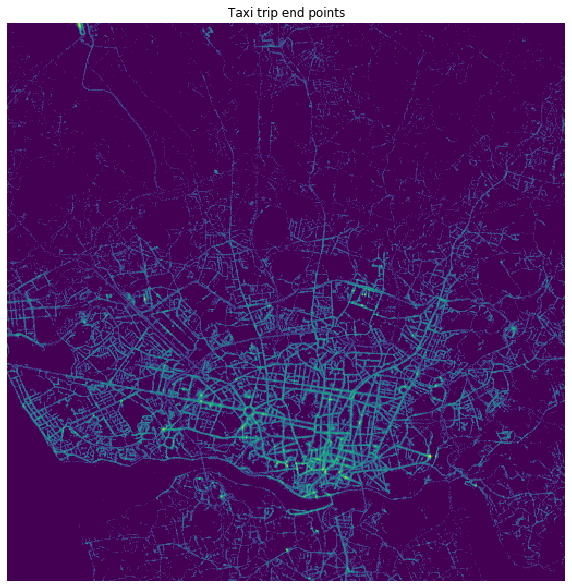

In [3]:
#visualising coordinates from train dataset
latlong = np.array([[p[0][1], p[0][0]] for p in df['POLYLINE'] if len(p)>0])

# cut off long distance trips
lat_low, lat_hgh = np.percentile(latlong[:,0], [2, 98])
lon_low, lon_hgh = np.percentile(latlong[:,1], [2, 98])

# create image
bins = 513
lat_bins = np.linspace(lat_low, lat_hgh, bins)
lon_bins = np.linspace(lon_low, lon_hgh, bins)
H2, _, _ = np.histogram2d(latlong[:,0], latlong[:,1], bins=(lat_bins, lon_bins))
img = np.log(H2[::-1, :] + 1)
plt.figure(figsize=(10,12))
ax = plt.subplot(1,1,1)
plt.imshow(img)
plt.axis('off')
plt.title('Taxi trip end points')
plt.show()

In [4]:
df1 = df.dropna(subset = ['POLYLINE'])
df1 =df1.fillna(0)

In [5]:
df1

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,0.0,0.0,20000589,1372636858,A,False,"[[-8.630838, 41.154489]]"
1,1372637303620000596,B,0.0,7.0,20000596,1372637303,A,False,"[[-8.66574, 41.170671]]"
2,1372636951620000320,C,0.0,0.0,20000320,1372636951,A,False,"[[-8.61597, 41.14053]]"
3,1372636854620000520,C,0.0,0.0,20000520,1372636854,A,False,"[[-8.607996, 41.142915]]"
4,1372637091620000337,C,0.0,0.0,20000337,1372637091,A,False,"[[-8.687268, 41.178087]]"
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,0.0,0.0,20000698,1404171463,A,False,"[[-8.611344, 41.171013]]"
1710666,1404171367620000670,C,0.0,0.0,20000670,1404171367,A,False,"[[-8.627454, 41.158755]]"
1710667,1388745716620000264,C,0.0,0.0,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,0.0,12.0,20000248,1404141826,A,False,"[[-8.587026, 41.173524]]"


In [6]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df1, train_size = 0.1, random_state=0)

In [7]:
#encoding categoricals, dropping TRIP_ID and TAXI_ID
df_train['CALL_TYPE'] = pd.factorize(df_train['CALL_TYPE'])[0]
df_train['DAY_TYPE'] = pd.factorize(df_train['DAY_TYPE'])[0]
df_train['MISSING_DATA'] = pd.factorize(df_train['MISSING_DATA'])[0]
df_train.drop('TRIP_ID', inplace = True, axis = 1)
df_train.drop('TAXI_ID', inplace = True, axis = 1)

df_val['CALL_TYPE'] = pd.factorize(df_val['CALL_TYPE'])[0]
df_val['DAY_TYPE'] = pd.factorize(df_val['DAY_TYPE'])[0]
df_val['MISSING_DATA'] = pd.factorize(df_val['MISSING_DATA'])[0]
df_val.drop('TRIP_ID', inplace = True, axis = 1)
df_val.drop('TAXI_ID', inplace = True, axis = 1)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [8]:
#spliting train data for memory reduction
df_val1, df_val2 = train_test_split(df_val,train_size = 0.001, random_state = 0)

In [9]:
#creating table with "lat" and "long" columns for train data
import torch
features = df_train.drop('POLYLINE', axis = 1).values
target = df_train['POLYLINE'].values

max_length = max(len(row) for row in target)
max_cols = max([len(row) for batch in target for row in batch])
max_rows = max([len(batch) for batch in target])
padded = [batch + [[0] * (max_cols)] * (max_rows - len(batch)) \
          for batch in target]
padded = torch.tensor([row + [0] * (max_cols - len(row)) \
                       for batch in padded for row in batch])
padded = padded.view(-1, max_rows, max_cols)

lat = padded[:,0][:,0]
long = padded[:,0][:,1]
targ = pd.DataFrame()
targ['lat']  = lat
targ['long'] = long

In [10]:
#creating table with "lat" and "long" columns for val data
features_val = df_val1.drop('POLYLINE', axis = 1).values
target_val = df_val1['POLYLINE'].values

max_length = max(len(row) for row in target_val)
max_cols = max([len(row) for batch in target_val for row in batch])
max_rows = max([len(batch) for batch in target_val])
padded_val = [batch + [[0] * (max_cols)] * (max_rows - len(batch)) \
               for batch in target_val]
padded_val = torch.tensor([row + [0] * (max_cols - len(row)) \
                            for batch in padded_val for row in batch])
padded_val = padded_val.view(-1, max_rows, max_cols)

lat_val = padded_val[:,0][:,0]
long_val = padded_val[:,0][:,1]
targ_val = pd.DataFrame()
targ_val['lat']  = lat_val
targ_val['long'] = long_val
#targ

In [11]:
#normalising data with StandardScaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))

df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

<b>Построим перцептрон с 2 скрытыми слоями, обучим его и посмотрим на график функции потерь.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 16936526.0
epoch 100, loss 16666963.0
epoch 200, loss 16070822.0
epoch 300, loss 14466384.0
epoch 400, loss 12546584.0
epoch 500, loss 11843390.0
epoch 600, loss 10862563.0
epoch 700, loss 9160946.0
epoch 800, loss 5731308.0
epoch 900, loss 273344.46875
epoch 1000, loss 73823.125
epoch 1100, loss 73705.9140625
epoch 1200, loss 73608.3125
epoch 1300, loss 73520.515625
epoch 1400, loss 73441.796875
epoch 1500, loss 73374.59375
epoch 1600, loss 73316.5546875
epoch 1700, loss 73267.6640625
epoch 1800, loss 73227.7109375
epoch 1900, loss 73197.5390625
epoch 2000, loss 73174.9296875
epoch 2100, loss 73156.671875
epoch 2200, loss 73140.984375
epoch 2300, loss 73128.703125
epoch 2400, loss 73120.5625


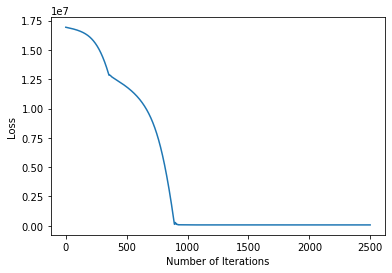

In [17]:
from torch.nn import L1Loss,LeakyReLU
import torch.nn as nn

# N - batch_size; 
# D_in - input shape;
# Hi - shape of layer i; 
# D_out - output shape

N, D_in, H, H1, D_out = 500, 6, 5, 4, 2

model0 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list0 = []
learning_rate = 0.001
optimizer = torch.optim.Adam(model0.parameters(),
                             lr=learning_rate,
                            )
EPOCH = 2500
for epoch in range(EPOCH):
    #predicting long
    y_pred = model0(X.float())
    y_pred1 = y_pred[0]
    #predicting lat
    y_pred2 = y_pred[1]
    #loss = sum of loss for lat and long preds
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list0.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

#visualising loss
plt.plot(range(EPOCH),loss_list0)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [18]:
#predicting on val data
model0.eval() 
val_preds = pd.DataFrame(model0(X_val.float()).data.numpy())
#calculating meanhaversine distance (km)
mean_haversine(val_preds[1],val_preds[0],targ_val['long'], targ_val['lat'])

2355.2183435015904

<b>Increasing learning rate from 0.001 to 0.1</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 16931672.0
epoch 100, loss 557598.75
epoch 200, loss 396238.78125
epoch 300, loss 264797.65625
epoch 400, loss 327578.75


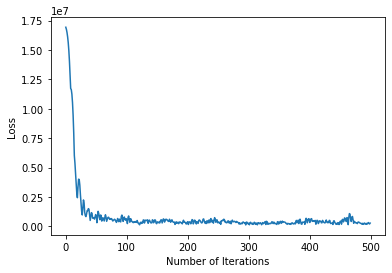

In [74]:
from torch.nn import L1Loss,LeakyReLU
import torch.nn as nn

N, D_in, H, H1, D_out = 500, 6, 5, 4, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))


plt.plot(range(EPOCH),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [75]:
model.eval() 
val_preds = pd.DataFrame(model(X_val.float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'], targ_val['lat'])

1513.8017624562985

<b>Changing gradient descent method to SGD.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 17124676.0
epoch 100, loss nan
epoch 200, loss nan
epoch 300, loss nan
epoch 400, loss nan


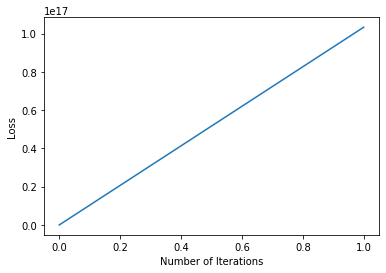

In [76]:
from torch.nn import L1Loss,LeakyReLU
import torch.nn as nn

N, D_in, H, H1, D_out = 50, 6, 5, 4, 2

model01 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list01 = []
learning_rate = 0.1
optimizer = torch.optim.SGD(model01.parameters(),
                             lr=learning_rate,
                            momentum = 0.2)
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model01(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list01.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list01)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

<b>SGD returns nans due to the gradient explosion. Momentum is not very helpful. Hence this gradient descent method is not suitable for the prolem considered.</b>

<b>Adding Dropout layer.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 16928348.0
epoch 100, loss 4330194.0
epoch 200, loss 754339.5625
epoch 300, loss 357671.0
epoch 400, loss 207443.28125


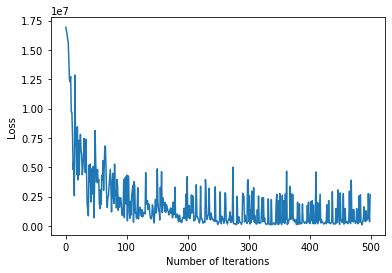

In [77]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 10, 5, 2

#Adding normalisation and dropout ayers for overfitting prevention
#and increased perceptron efficiency

model1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.25),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.05),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list1 = []
learning_rate = 0.1

optimizer = torch.optim.Adam(model1.parameters(),
                             lr=learning_rate,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model1(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list1.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list1)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [78]:
model1.eval() 
val_preds = pd.DataFrame(model1(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

491.65859099280163

<b>Changing dropout p-value.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 17239628.0
epoch 100, loss 298360.03125
epoch 200, loss 336981.21875
epoch 300, loss 217075.796875
epoch 400, loss 274642.84375


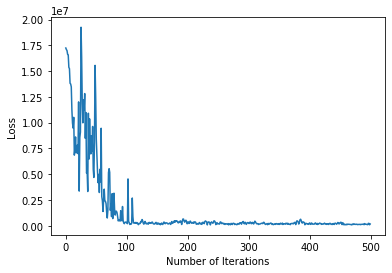

In [79]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 10, 5, 2

model2 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.85),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list2 = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model2.parameters(),
                             lr=learning_rate,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model2(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list2.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list2)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [80]:
model2.eval() 
val_preds = pd.DataFrame(model2(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

98.3167102776404

<b>Adding L2-regularisation (weight_decay).</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 17125912.0
epoch 100, loss 1038333.875
epoch 200, loss 268122.5
epoch 300, loss 344248.4375
epoch 400, loss 152148.1875


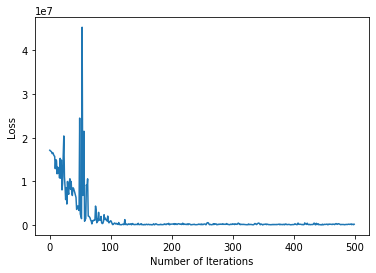

In [81]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 10, 5, 2

model3 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.85),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list3 = []
learning_rate = 0.1

optimizer = torch.optim.Adam(model3.parameters(),
                             lr=learning_rate, 
                             weight_decay = 0.7,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model3(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list3.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list3)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [82]:
model3.eval() 
val_preds = pd.DataFrame(model3(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

115.65671680241579

<b>Trying to decrease the value of weight_decay.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 17025076.0
epoch 100, loss 2037095.875
epoch 200, loss 507242.6875
epoch 300, loss 247421.46875
epoch 400, loss 158972.015625


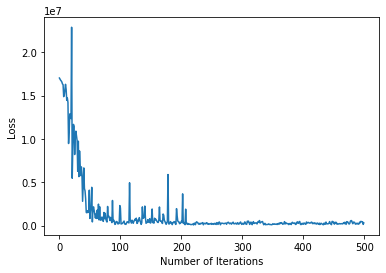

In [83]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 10, 5, 2

model31 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.85),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list31 = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model31.parameters(),
                             lr=learning_rate, 
                             weight_decay = 0.001,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model31(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list31.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list31)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [84]:
model31.eval() 
val_preds = pd.DataFrame(model31(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

180.3039212865063

<b>Decreasing L2 improved the score. </b>

<b>Adding normalisation of the 1st layer.</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 16857638.0
epoch 100, loss 3213469.75
epoch 200, loss 827497.75
epoch 300, loss 169835.25
epoch 400, loss 104621.4609375


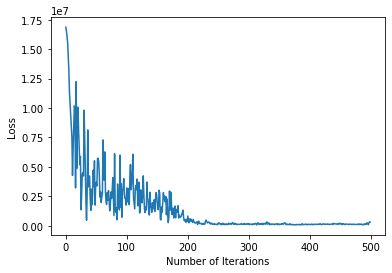

In [85]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 10, 5, 2

model4 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.BatchNorm1d(H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.25),
    torch.nn.Linear(H, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list4 = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model4.parameters(),
                             lr=learning_rate, 
                             weight_decay = 0.001,
                            )
EPOCH = 500
for epoch in range(EPOCH):
    y_pred = model4(X.float())
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list4.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list4)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [86]:
model4.eval() 
val_preds = pd.DataFrame(model4(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

42.23751877988462

<b>Searching for the optimal combination of all params</b>

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 16921286.0
epoch 100, loss 5166317.0
epoch 200, loss 8737546.0
epoch 300, loss 1983700.75
epoch 400, loss 5978654.0
epoch 500, loss 1587545.25
epoch 600, loss 1587993.0
epoch 700, loss 153154.796875
epoch 800, loss 80630.796875
epoch 900, loss 73536.984375


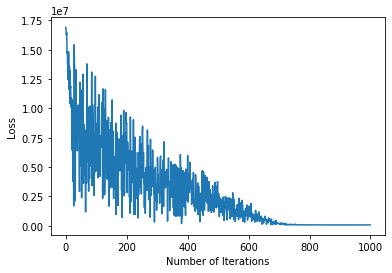

In [87]:
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 15, 5, 2

model6 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.BatchNorm1d(H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.85),
    torch.nn.Linear(H, H1),
    torch.nn.LayerNorm(H1),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.65),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list6 = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model6.parameters(),
                             lr=learning_rate, 
                             weight_decay = 0.001,
                            )
EPOCH = 1000
for epoch in range(EPOCH):
    y_pred1 = model6(X.float())[0]
    y_pred2 = model6(X.float())[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list6.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list6)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [88]:
model6.eval() 
val_preds = pd.DataFrame(model6(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

3.5705325718244603

C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\Asus\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([171067, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch 0, loss 17294752.0
epoch 100, loss 8188969.0
epoch 200, loss 9417572.0
epoch 300, loss 2556541.75
epoch 400, loss 3786717.0
epoch 500, loss 1611353.5
epoch 600, loss 1886776.25
epoch 700, loss 352185.1875
epoch 800, loss 135166.484375
epoch 900, loss 74065.390625
epoch 1000, loss 73146.171875
epoch 1100, loss 73338.6484375
epoch 1200, loss 73153.7578125
epoch 1300, loss 73239.921875
epoch 1400, loss 73149.8046875


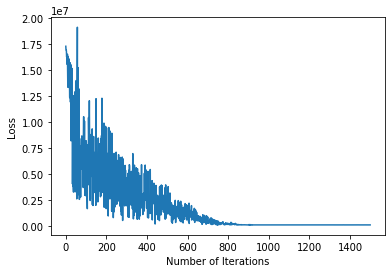

In [14]:
from torch.nn import L1Loss,LeakyReLU
import torch.nn as nn
df_train_ss = ss.fit_transform(df_train.drop('POLYLINE', axis =1 ))
X = torch.from_numpy(df_train_ss)
y = torch.from_numpy(np.array(targ))
df_val_ss = ss.fit_transform(df_val1.drop('POLYLINE', axis =1 ))
X_val = torch.from_numpy(df_val_ss)
y_val = torch.from_numpy(np.array(targ_val)).float()

N, D_in, H, H1, D_out = 500, 6, 15, 5, 2

model7 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.BatchNorm1d(H),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.85),
    torch.nn.Linear(H, H1),
    torch.nn.LayerNorm(H1),
    torch.nn.LeakyReLU(),
    nn.Dropout(p=0.65),
    torch.nn.Linear(H1, D_out),
)

loss_fn = torch.nn.L1Loss(size_average=False)
loss_list7 = []
learning_rate = 0.1
optimizer = torch.optim.Adam(model7.parameters(),
                             lr=learning_rate, 
                             weight_decay = 0.7,
                            )
EPOCH = 1500
for epoch in range(EPOCH):
    y_pred = model7(X.float()).unsqueeze_(1)
    y_pred1 = y_pred[0]
    y_pred2 = y_pred[1]
    loss = loss_fn(y_pred1, y) + loss_fn(y_pred2, y)
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    loss_list7.append(loss.data)
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(EPOCH),loss_list7)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [15]:
model7.eval() 
val_preds = pd.DataFrame(model7(X_val[:500].float()).data.numpy())
mean_haversine(val_preds[1],val_preds[0],targ_val['long'][:500], targ_val['lat'][:500])

3.640390682697246

In [16]:
val_preds.head(20)

,0,1
0,-8.615013,41.162037
1,-8.615002,41.163097
2,-8.614991,41.162857
3,-8.615019,41.163811
4,-8.615006,41.163876
5,-8.614997,41.163029
6,-8.614996,41.163017
7,-8.615009,41.163849
8,-8.615019,41.163925
9,-8.615031,41.163860


In [17]:
#importing test dataset
zf = zipfile.ZipFile('test.csv.zip')
df_test = pd.read_csv(zf.open('test.csv'), converters={'POLYLINE': lambda x: json.loads(x)[-1:]})

In [18]:
#preprocessing test data in the way similar to that used for train data
drop = ['POLYLINE','TRIP_ID', 'TAXI_ID']
feats_test = df_test.drop(drop, axis =1)
feats_test['CALL_TYPE'] = pd.factorize(feats_test['CALL_TYPE'])[0]
feats_test['DAY_TYPE'] = pd.factorize(feats_test['DAY_TYPE'])[0]
feats_test['MISSING_DATA'] = pd.factorize(feats_test['MISSING_DATA'])[0]
feats_test =feats_test.fillna(0)
ss = StandardScaler()
feats_test_ss = ss.fit_transform(feats_test)
X_test = torch.from_numpy(feats_test_ss)

In [19]:
#predicting coordinates in test dataset
predictions_test = pd.DataFrame(model7(X_test.float()).data.numpy())

In [20]:
final_preds = pd.DataFrame()
final_preds['TRIP_ID'] = df_test['TRIP_ID']
final_preds['LATITUDE'] = predictions_test[1]
final_preds['LONGITUDE'] = predictions_test[0]
final_preds.head(50)

,TRIP_ID,LATITUDE,LONGITUDE
0,T1,41.163540,-8.615007
1,T2,41.163811,-8.615026
2,T3,41.163540,-8.615007
3,T4,41.163807,-8.615025
4,T5,41.163620,-8.615008
5,T6,41.162464,-8.615001
6,T7,41.163540,-8.615007
7,T8,41.162647,-8.615001
8,T9,41.163380,-8.615005
9,T10,41.163540,-8.615007


In [21]:
#saving predictions to csv
final_preds.to_csv('final_preds.csv', index = False)

In [63]:
#kaggle public score = 3.42750